# Reconsidering P-values in Econometrics

A large number of academic papers based on the analysis of a dataset claim to conclude their discussions by presenting the p-values associated with the coefficients of linear models used in various econometric techniques. To recap, a low p-value associated with a coefficient is often interpreted as evidence that this coefficient is not zero merely by chance, but that it holds some statistical significance.

However, in my experience, relying solely on p-values and conventional significance tests (e.g., deeming a coefficient significant if p-value < 5%) is insufficient. These tests can easily be misleading if the econometric design is flawed, or if biases are introduced by the user. In this notebook, we will explore such scenarios, demonstrating how p-values can be unreliable indicators in the presence of poor experimental design or user bias.

Cyril Joly

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
class LinearRegressionWithPValues(LinearRegression):
    def fit(self, X, y):
        self = super().fit(np.asarray(X), y)
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns
            X = X.values
        else:
            self.feature_names = [f'X{i}' for i in range(X.shape[1])]

        n, p = X.shape
        dof = n - p

        mse = np.sum((self.predict(np.asarray(X)) - y) ** 2) / dof

        X_matrix = np.asarray(X)
        cov_matrix = np.linalg.inv(X_matrix.T.dot(X_matrix))
        self.se = np.sqrt(np.diagonal(cov_matrix) * mse)

        self.t_stats = self.coef_ / self.se

        self.p_values = 2 * (1 - stats.t.cdf(np.abs(self.t_stats), dof))
        return self

    def summary(self):
        for name, coef, p in zip(self.feature_names, self.coef_, self.p_values):
            stars = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
            print(f"{name}:\n\tcoef = {coef:.4f}\n\tp-value = {p:.4f} {stars}")
        print(f"intercept: {self.intercept_:.4f}")

# 1. Potential Bias or Flaws in Experimental Design

Consider a simple model of an experiment:  
$$y_t = \alpha \times x_t + \beta \times \mathbb{1}_{t \geq t_0} + \gamma + \epsilon_t$$
Here:
- $ y_t $ is the response variable at time $ t $, influenced by the signal $ x_t $,
- $ t_0 $ marks the moment of a shift that impacts the response,
- $ \epsilon_t $ represents random noise.

However, if the experimenter mistakenly assumes a different event time, denoted by $ t_1 \neq t_0 $, this can lead to erroneous conclusions about causality. The experiment may yield misleading results, suggesting a significant impact of the wrong event on the response variable. Despite the incorrect specification, the p-values of the model's coefficients can still be very small (e.g., less than 0.001), potentially flagged with the three-star notation (***), which may mislead the researcher into believing that the wrong event is strongly causal.

### Numerical Example

In [3]:
time = np.linspace(0, 1, 1001)
alpha, beta, gamma = 1.0, 0.4, 0.0
x = np.sin(2 * np.pi * time)
t0 = 0.7  # Actual onset of the event
t1 = 0.5  # Incorrectly assumed onset
indicator_true = (time > t0).astype(float)
indicator_false = (time > t1).astype(float)
noise = 0.4 * np.random.randn(len(time))
y = alpha * x + beta * indicator_true + gamma + noise

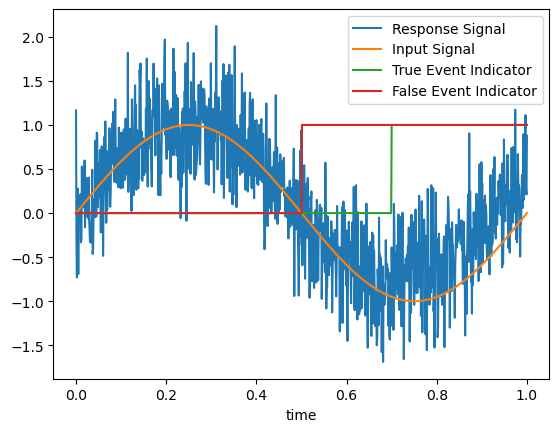

In [4]:
plt.plot(time, y, label='Response Signal')
plt.plot(time, x, label='Input Signal')
plt.plot(time, indicator_true, label='True Event Indicator')
plt.plot(time, indicator_false, label='False Event Indicator')
plt.xlabel('time')
plt.legend()
plt.show()

In this case, we correctly account for the event at $ t_0 = 0.7 $ by using `indicator_true`. The model will capture the correct parameters, and the p-values for the coefficients will be negligible, accurately reflecting the strength of the relationship between the event and the response.

In [5]:
X = pd.DataFrame()
X['signal'] = x
X['event_indicator'] = indicator_true

y = pd.Series(y)

model = LinearRegressionWithPValues().fit(X, y)
model.summary()

signal:
	coef = 1.0143
	p-value = 0.0000 ***
event_indicator:
	coef = 0.3876
	p-value = 0.0000 ***
intercept: 0.0099


### Introducing Bias with an Incorrect Event Time

Now, let's see what happens when we mistakenly assume that the event occurs at $ t_1 = 0.5 $ instead of $ t_0 = 0.7 $. We use `indicator_false` to encode this incorrect event time in the model. Despite this error, the model might still produce very low p-values, misleading the researcher into believing that the event at $ t_1 $ is the actual cause of the drift in the data.

In [6]:
X = pd.DataFrame()
X['signal'] = x
X['event_indicator'] = indicator_false

y = pd.Series(y)

model = LinearRegressionWithPValues().fit(X, y)
model.summary()

signal:
	coef = 0.9669
	p-value = 0.0000 ***
event_indicator:
	coef = 0.1799
	p-value = 0.0000 ***
intercept: 0.0366


### Conclusion

When modeling events in experiments, incorrectly specifying the timing of a shift (e.g., using the wrong event time) can still produce highly significant p-values, potentially leading researchers to draw false conclusions about causality. Properly designed indicator variables, which correctly capture the timing of events, are crucial for accurately identifying the true impact on the response signal.

However, this issue can be mitigated by using more advanced methods. For instance, **apyxl**, a package based on regression-tree algorithms, is capable of discovering the time spans of shifts autonomously, without requiring the user to specify the event timing in advance. This approach minimizes the risk of introducing user biases, ensuring a more reliable detection of causal events in the data.